<a href="https://colab.research.google.com/github/irith-k/SAIL/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset setup

Imports

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from scipy.stats import norm
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data.dataset import TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import random

Loading the train and test datasets

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
training_X = []; training_y = []; test_X = []; test_y = []
for x, y in training_data:
  training_X.append(x)
  training_y.append(y)
for x, y in test_data:
  test_X.append(x)
  test_y.append(y)

Plotting digits in the dataset

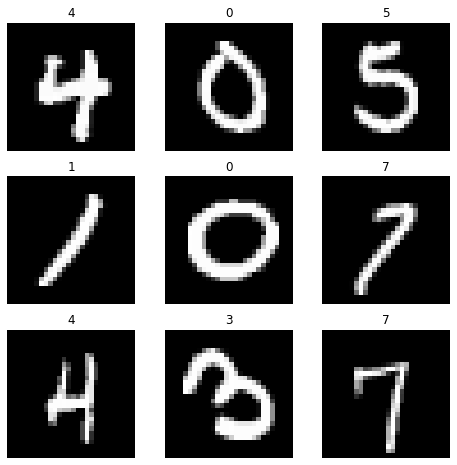

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Average digit

In [ ]:
dig_dict = {}
for i in range(len(training_data)):
  img, label = training_data[i]
  dig_dict.setdefault(label, []).append(img)

In [ ]:
prototype = {}
for y in dig_dict:
  prototype[y] = torch.cat(dig_dict[y], 0).mean(dim=0)

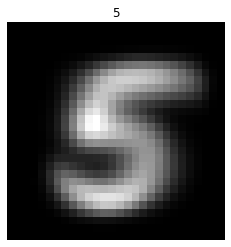

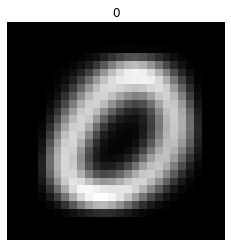

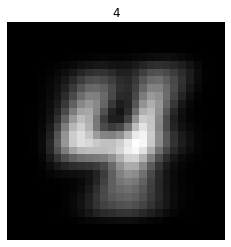

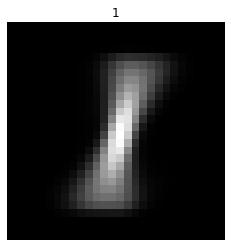

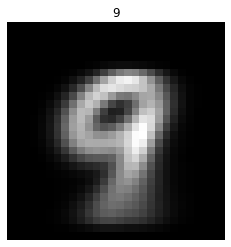

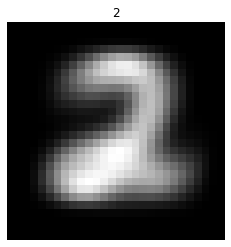

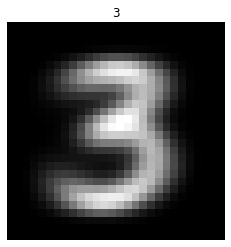

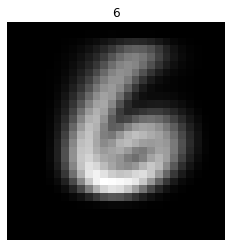

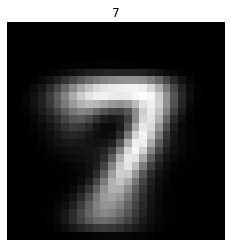

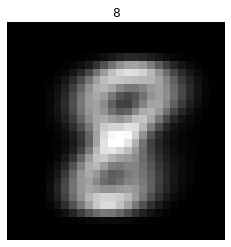

In [ ]:
for x in prototype:
  plt.title(x)
  plt.axis("off")
  plt.imshow(prototype[x].squeeze(), cmap="gray")
  plt.show()

Standard deviation digit

In [ ]:
epsilon = 10**-5
stddevs = {}
for y in dig_dict:
  stddevs[y] = torch.cat(dig_dict[y], 0).std(dim=0) + epsilon

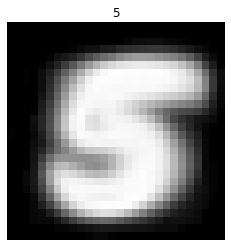

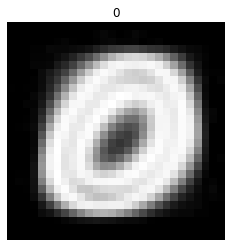

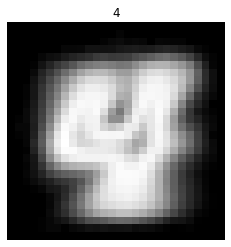

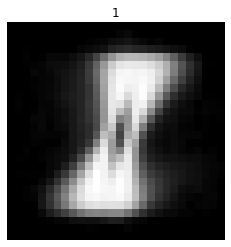

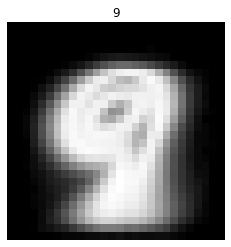

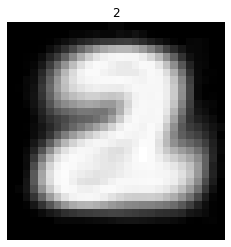

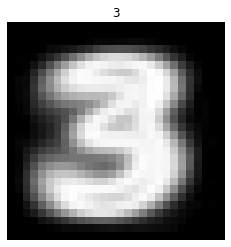

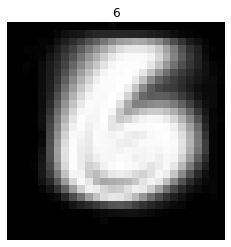

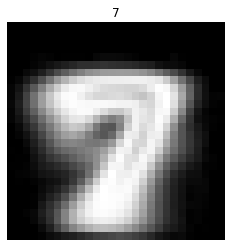

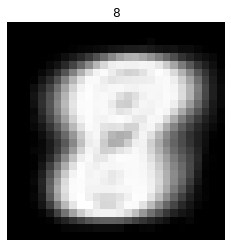

In [ ]:
for x in stddevs:
  plt.title(x)
  plt.axis("off")
  plt.imshow(stddevs[x].squeeze(), cmap="gray")
  plt.show()

#Euclidean classifier

Scikit-learn Euclidean classifier

In [5]:
class EuclideanClassifier(BaseEstimator, ClassifierMixin):  
  """Classify samples based on the distance from the mean feature value"""

  def __init__(self):
    self.X_mean_ = None

  def fit(self, X, y):
    """
    This should fit classifier. All the "work" should be done here.
    
    Calculates self.X_mean_ based on the mean 
    feature values in X for each class.
    
    self.X_mean_ becomes a numpy.ndarray of shape 
    (n_classes, n_features)
    
    fit always returns self.
    """
    dig_dict = {}
    for i in range(len(X)):
      img = X[i]
      label = y[i]
      dig_dict.setdefault(label, []).append(img)
    dig_keys = list(dig_dict.keys())
    dig_keys.sort()
    dig_dict = {i: dig_dict[i] for i in dig_keys}
    self.X_mean_ = []
    for y in dig_dict:
      a = torch.cat(dig_dict[y], dim=0).mean(dim=0).numpy()
      self.X_mean_.append(a)
    self.X_mean_ = np.array(self.X_mean_)
    return self

  def predict(self, X):
    """
    Make predictions for X based on the
    euclidean distance from self.X_mean_
    """
    preds = []
    for i in range(len(X)):
      distance = [((v - X[i]) ** 2).sum().item() for v in torch.from_numpy(self.X_mean_)]
      pred = distance.index(min(distance))
      preds.append(pred)
    return preds
  
  def score(self, X, y):
    """
    Return accuracy score on the predictions
    for X based on ground truth y
    """
    correct = 0
    for i in range(len(X)):
      distance = [((v - X[i]) ** 2).sum().item() for v in torch.from_numpy(self.X_mean_)]
      pred = distance.index(min(distance))
      if(pred == y[i]):
        correct += 1
    score = correct/len(y)
    return score

In [54]:
model = EuclideanClassifier()

In [55]:
model.fit(training_X, training_y)

EuclideanClassifier()

In [56]:
model.score(test_X, test_y)

0.8203

Learning curve plot for different train sizes



In [6]:
train_sizes, train_scores, test_scores = learning_curve(estimator=EuclideanClassifier(), X=training_X, y=training_y, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], cv=3)

In [7]:
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

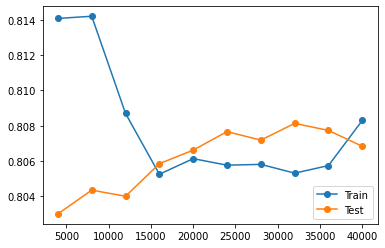

In [8]:
plt.plot(train_sizes, train_scores_mean, label="Train", marker="o")
plt.plot(train_sizes, test_scores_mean, label="Test", marker="o")
plt.legend(loc="lower right")
plt.show()

#Dimensionality reduction for plotting

Naive plot of empirical distribution of data

In [ ]:
# Naive approach: try grabbing n random pixels and use those to display the data on a grid
class MyNaiveClassifier():  
  def __init__(self, n_components):
    self.n_components = n_components
    self.components = np.zeros(n_components)

  def fit(self, X):
    X_flatten = torch.flatten(X, start_dim=1)
    d = X_flatten.size(1)
    for i in range(self.n_components):
      while True:
        self.components[i] = random.randint(0, d-1)
        unique = True
        for j in range(i):
          if(self.components[j] == self.components[i]):
            unique = False
        if unique:
          break
    return self
  
  def transform(self, X):
    X_flatten = torch.flatten(X, start_dim=1)
    return X_flatten[:,self.components]
  
  def fit_transform(self, X):
    self.fit(X)
    return self.transform(X)

In [14]:
training_X = []; training_y = []; test_X = []; test_y = []
for x, y in training_data:
  training_X.append(x)
  training_y.append(y)
for x, y in test_data:
  test_X.append(x)
  test_y.append(y)
training_X = torch.cat(training_X)
test_X = torch.cat(test_X)
training_y = torch.tensor(training_y)
test_y = torch.tensor(test_y)

In [ ]:
model = MyNaiveClassifier(n_components=100)
model.fit_transform(training_X).shape

torch.Size([60000, 100])

In [ ]:
s = set(model.components)
len(s) == len(model.components)

True

Principal Component Analysis (PCA)

In [ ]:
# TODO

#Naive Bayes classifier

Naive Bayes classifier as scikit-learn estimator

In [9]:
class NaiveBayes(BaseEstimator, ClassifierMixin):  

  def __init__(self, ep):
    self.ep = ep
    self.freq = None
    self.means = None
    self.stddevs = None

  def fit(self, X, y):
    dig_dict = {}
    for i in range(len(X)):
      img = X[i]
      label = y[i]
      dig_dict.setdefault(label, []).append(img)
    dig_keys = list(dig_dict.keys())
    dig_keys.sort()
    dig_dict = {i: dig_dict[i] for i in dig_keys}
    self.freq = []
    self.means = []
    self.stddevs = []
    for y in dig_dict:
      self.freq.append(len(dig_dict[y]) / len(X))
      self.means.append(torch.cat(dig_dict[y], dim=0).mean(dim=0).numpy())
      self.stddevs.append((torch.cat(dig_dict[y], dim=0).std(dim=0) + self.ep).numpy())
    self.freq = np.array(self.freq)
    self.means = np.array(self.means)
    self.stddevs = np.array(self.stddevs)
    return self

  def predict(self, X):
    return 0

  def score(self, X, y):
    correct = 0
    for i in range(len(X)):
      '''
      Numerical instabilities with original naive Bayes formula:
      - Some pixels have 0 deviation: add small constant (epsilon) to all deviations, or clipping
      - PDF is not bounded from above, so product of these large values can result in infinity: compute log-probabilities
        - Relative order is preserved since log is increasing function, and breaks products into sums
      - Log approaches negative infinity when probability approaches 0: clip to interval (lower bound), or add small constant 
      '''
      prob = [np.log(np.clip(norm.pdf(X[i], self.means[y], self.stddevs[y]).squeeze(), 10**-10, None)).sum() + np.log(self.freq[y]) for y in range(len(self.freq))]
      pred = prob.index(max(prob))
      if pred == y[i]:
        correct += 1
    return correct/len(X)*100

In [15]:
model = NaiveBayes(ep=10**-5)

In [16]:
model.fit(training_X, training_y)

NaiveBayes(ep=1e-05)

In [ ]:
model.score(test_X, test_y)

GaussianNB (sklearn built-in estimator)

In [ ]:
training_X = torch.cat(training_X)
test_X = torch.cat(test_X)
training_y = torch.tensor(training_y)
test_y = torch.tensor(test_y)

In [ ]:
training_X = torch.flatten(training_X, start_dim=1)
test_X = torch.flatten(test_X, start_dim=1)

In [ ]:
gnb = GaussianNB()
gnb.fit(training_X, training_y)
y_pred = torch.from_numpy(gnb.predict(test_X))

In [ ]:
print(torch.sum(y_pred == test_y).item()/len(test_y)*100)

#SVM

Support vector classification

In [ ]:
clf = svm.LinearSVC() # LinearSVC is a faster implementation of SVC for the case of a linear kernel, used with large datasets

In [ ]:
clf.fit(training_X, training_y)

In [ ]:
clf.score(test_X, test_y)

#Neural networks

Neural network architecture

In [ ]:
w = training_X.shape[-2]
h = training_X.shape[-1]

In [ ]:
class NeuralNetwork(nn.Module):
  # The constructor to your Module only initializes your layer types 
  # PyTorch keeps track of these variables, but it has no idea how the layers connect to each other
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(w * h, 100)
    self.layer2 = nn.Linear(100, 10)
  # For PyTorch to understand the network architecture you’re building, you define the forward function
  # Inside the forward function you take the variables initialized in your constructor and connect them
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.layer1(x.flatten(start_dim=1))
    x = F.relu(x)
    x = self.layer2(x)
    return x

Feedforward neural network model

In [43]:
training_X = []; training_y = []; test_X = []; test_y = []
for x, y in training_data:
  training_X.append(x)
  training_y.append(y)
for x, y in test_data:
  test_X.append(x)
  test_y.append(y)
training_X = torch.cat(training_X)
test_X = torch.cat(test_X)
training_y = torch.tensor(training_y)
test_y = torch.tensor(test_y)

In [ ]:
class NeuralNet(BaseEstimator, ClassifierMixin):  

    def __init__(self, lr=1e-2, opt_class=optim.SGD, num_epochs=10, weight_decay=0, loss_function=nn.CrossEntropyLoss(), batch_size=64):
        self.nn = NeuralNetwork()
        self.lr = lr
        self.opt_class = opt_class
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.optimizer = opt_class(self.nn.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        self.loss_function = loss_function

    def fit(self, X, y):
        self.nn.train()
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        for epoch in range(self.num_epochs):
          for x, y_lbl in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            y_pred = self.nn(x)
            loss = self.loss_function(y_pred, y_lbl)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return self

    def predict(self, X):
      self.nn.eval()
      preds = []
      dataloader = DataLoader(X, batch_size=self.batch_size)
      with torch.no_grad():
        for x in dataloader:
          y_pred = self.nn(x)
          preds.append(y_pred)
      return torch.cat(preds).argmax(dim=-1)
    
    def score(self, X, y):
      preds = self.predict(X)
      s = (y == preds).sum()
      return (s/len(y)).item()

In [ ]:
learning_rate = 1e-2
num_epochs = 10
batch_size = 64
weight_decay = 0

In [ ]:
model = NeuralNet(learning_rate, optim.SGD, num_epochs, weight_decay, nn.CrossEntropyLoss(), batch_size)
model.fit(training_X, training_y)
model.score(test_X, test_y)

0.9307000041007996

Grid search for finetuned hyperparameters

In [ ]:
param_grid = {
    'lr': [1e-2], 
    'opt_class': [optim.SGD, optim.Adam], 
    'num_epochs': [10], 
    'weight_decay': [0, 1e-3], 
    'loss_function': [nn.CrossEntropyLoss()], 
    'batch_size': [64],
}

In [ ]:
estimator = NeuralNet()

In [ ]:
gs_nn = GridSearchCV(estimator, param_grid, cv=3, n_jobs=-1, verbose=10)

In [ ]:
gs_nn.fit(training_X, training_y)

In [ ]:
gs_nn.best_params_

{'batch_size': 64,
 'loss_function': CrossEntropyLoss(),
 'lr': 0.01,
 'num_epochs': 10,
 'opt_class': torch.optim.sgd.SGD,
 'weight_decay': 0}

In [ ]:
gs_nn.score(test_X, test_y)

0.897599995136261

Image augmentation (torchvision.transforms)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomInvert(0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=(-30, 30))], p=0.5),
    transforms.CenterCrop(20)
])

In [ ]:
bad_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

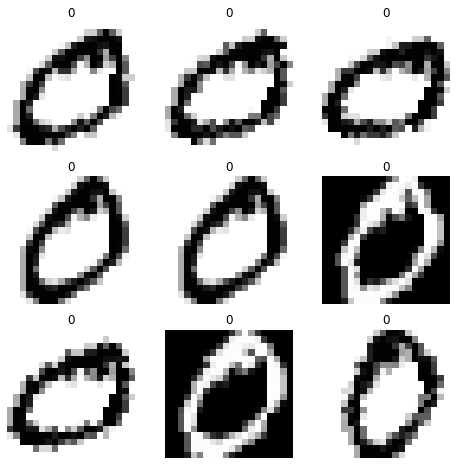

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = 1
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Convolutional neural network

In [ ]:
class LeNet(nn.Module):
  def __init__(self, numChannels, classes):
    # call the parent constructor
    super().__init__()
    # initialize first set of CONV => RELU => POOL layers
    self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20,
      kernel_size=(5, 5))
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    # initialize second set of CONV => RELU => POOL layers
    self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    # initialize first (and only) set of FC => RELU layers
    self.fc1 = nn.Linear(in_features=800, out_features=500)
    self.relu3 = nn.ReLU()
    # initialize our softmax classifier
    self.fc2 = nn.Linear(in_features=500, out_features=classes)

  def forward(self, x):
    # pass the input through our first set of CONV => RELU => POOL layers
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)
    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)
    # flatten the output from the previous layer and pass it through our only set of FC => RELU layers
    x = x.flatten(start_dim=1)
    x = self.fc1(x)
    x = self.relu3(x)
    # pass the output to our softmax classifier to get our output
    # predictions
    x = self.fc2(x)
    # return the output predictions
    return x

In [ ]:
class ConvNeuralNet(BaseEstimator, ClassifierMixin):  

    def __init__(self, lr=1e-2, opt_class=optim.SGD, num_epochs=10,
                 weight_decay=0, loss_function=nn.CrossEntropyLoss(), batch_size=64, num_channels=1, classes=10, device="cpu"):
        self.device = device
        self.classes = classes
        self.num_channels = num_channels
        self.nn = LeNet(num_channels, classes).to(device)
        self.lr = lr
        self.opt_class = opt_class
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.optimizer = opt_class(self.nn.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        self.loss_function = loss_function
        self.training_history = []

    def fit(self, X, y, X_val=None, y_val=None):
        self.nn.train()
        self.nn = self.nn.to(self.device)
        dataset = TensorDataset(X[:, None], y) # X[:, None] adds dimension for num_channels
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        for epoch in range(self.num_epochs):
          for x, y_lbl in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            x, y_lbl = x.to(self.device), y_lbl.to(self.device)
            y_pred = self.nn(x)
            loss = self.loss_function(y_pred, y_lbl)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
          if X_val != None and y_val != None:
            accuracy = self.score(X_val, y_val)
            self.training_history.append(accuracy)
            print(f"Epoch {epoch+1}: {accuracy}")
        return self

    def predict(self, X):
      self.nn.eval()
      self.nn = self.nn.to(self.device)
      preds = []
      dataloader = DataLoader(X[:, None], batch_size=self.batch_size)
      with torch.no_grad():
        for x in dataloader:
          x = x.to(self.device)
          y_pred = self.nn(x).cpu()
          preds.append(y_pred)
      return torch.cat(preds).argmax(dim=-1)
    
    def score(self, X, y):
      preds = self.predict(X)
      s = (y == preds).sum()
      return (s/len(y)).item()

In [188]:
training_X = []; training_y = []; test_X = []; test_y = []
for x, y in training_data:
  training_X.append(x)
  training_y.append(y)
for x, y in test_data:
  test_X.append(x)
  test_y.append(y)
training_X = torch.cat(training_X)
test_X = torch.cat(test_X)
training_y = torch.tensor(training_y)
test_y = torch.tensor(test_y)

In [68]:
model = ConvNeuralNet(learning_rate, optim.SGD, 20, weight_decay, nn.CrossEntropyLoss(), batch_size, 1, 20, "cuda:0")

In [69]:
model.fit(training_X, training_y, test_X, test_y)

Epoch 1: 100%|██████████| 938/938 [00:02<00:00, 395.14it/s]


Epoch 1: 0.9125000238418579


Epoch 2: 100%|██████████| 938/938 [00:02<00:00, 325.09it/s]


Epoch 2: 0.9466999769210815


Epoch 3: 100%|██████████| 938/938 [00:02<00:00, 399.53it/s]


Epoch 3: 0.9671000242233276


Epoch 4: 100%|██████████| 938/938 [00:02<00:00, 403.45it/s]


Epoch 4: 0.9722999930381775


Epoch 5: 100%|██████████| 938/938 [00:02<00:00, 405.92it/s]


Epoch 5: 0.9714999794960022


Epoch 6: 100%|██████████| 938/938 [00:02<00:00, 378.77it/s]


Epoch 6: 0.9775999784469604


Epoch 7: 100%|██████████| 938/938 [00:02<00:00, 349.03it/s]


Epoch 7: 0.9818999767303467


Epoch 8: 100%|██████████| 938/938 [00:02<00:00, 393.24it/s]


Epoch 8: 0.9835000038146973


Epoch 9: 100%|██████████| 938/938 [00:02<00:00, 392.42it/s]


Epoch 9: 0.9815999865531921


Epoch 10: 100%|██████████| 938/938 [00:02<00:00, 404.98it/s]


Epoch 10: 0.9847000241279602


Epoch 11: 100%|██████████| 938/938 [00:02<00:00, 335.29it/s]


Epoch 11: 0.9846000075340271


Epoch 12: 100%|██████████| 938/938 [00:02<00:00, 391.71it/s]


Epoch 12: 0.9860000014305115


Epoch 13: 100%|██████████| 938/938 [00:02<00:00, 397.55it/s]


Epoch 13: 0.987500011920929


Epoch 14: 100%|██████████| 938/938 [00:02<00:00, 396.06it/s]


Epoch 14: 0.9869999885559082


Epoch 15: 100%|██████████| 938/938 [00:02<00:00, 399.72it/s]


Epoch 15: 0.9883000254631042


Epoch 16: 100%|██████████| 938/938 [00:02<00:00, 326.63it/s]


Epoch 16: 0.9882000088691711


Epoch 17: 100%|██████████| 938/938 [00:02<00:00, 387.09it/s]


Epoch 17: 0.9882000088691711


Epoch 18: 100%|██████████| 938/938 [00:02<00:00, 402.78it/s]


Epoch 18: 0.987500011920929


Epoch 19: 100%|██████████| 938/938 [00:02<00:00, 399.40it/s]


Epoch 19: 0.9890000224113464


Epoch 20: 100%|██████████| 938/938 [00:02<00:00, 349.85it/s]


Epoch 20: 0.9882000088691711


ConvNeuralNet(classes=20, device='cuda:0', num_epochs=20)

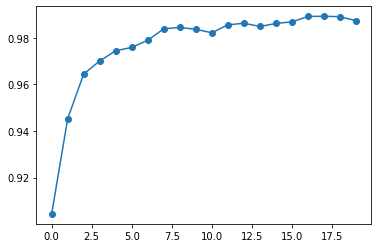

In [ ]:
plt.plot(model.training_history, marker="o")
plt.show()

In [ ]:
model.score(test_X, test_y)

0.9876999855041504

In [ ]:
print(model.nn.conv1.weight)
print(model.nn.conv1.bias)

In [ ]:
param_grid = {
    'lr': [1e-2], 
    'opt_class': [optim.SGD], 
    'num_epochs': [10, 20, 30, 40], 
    'weight_decay': [0], 
    'loss_function': [nn.CrossEntropyLoss()], 
    'batch_size': [64],
    'num_channels': [1],
    'classes': [10],
    'device': ["cuda:0"]
}

In [ ]:
estimator = ConvNeuralNet()

In [ ]:
gs_nn = GridSearchCV(estimator, param_grid, cv=3)

In [ ]:
gs_nn.fit(training_X, training_y)

In [ ]:
gs_nn.best_params_

{'batch_size': 64,
 'classes': 10,
 'device': 'cuda:0',
 'loss_function': CrossEntropyLoss(),
 'lr': 0.01,
 'num_channels': 1,
 'num_epochs': 40,
 'opt_class': torch.optim.sgd.SGD,
 'weight_decay': 0}

In [ ]:
gs_nn.score(test_X, test_y)

0.9894000291824341

In [ ]:
list(model.nn.children())[:-2]

[Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1)),
 ReLU(),
 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False),
 Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1)),
 ReLU(),
 MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False),
 Linear(in_features=800, out_features=500, bias=True)]

Saving and reloading trained model

In [35]:
torch.save(model, 'model.pth')

In [36]:
model = torch.load('model.pth')

In [37]:
model.score(test_X, test_y)

0.9889000058174133

#Representation learning

Embeddings

In [70]:
class LeNetEmbeddings(nn.Module):
  def __init__(self, cnn):
    # call the parent constructor
    super().__init__()
    self.cnn = cnn

  def forward(self, x):
    # pass the input through our first set of CONV => RELU => POOL layers
    x = self.cnn.conv1(x)
    x = self.cnn.relu1(x)
    x = self.cnn.maxpool1(x)
    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.cnn.conv2(x)
    x = self.cnn.relu2(x)
    x = self.cnn.maxpool2(x)
    # flatten the output from the previous layer and pass it through our only set of FC => RELU layers
    x = x.flatten(start_dim=1)
    x = self.cnn.fc1(x)
    return x

In [136]:
feature_extractor = LeNetEmbeddings(model.nn.cpu()).to("cuda:0").eval()

In [189]:
training_embeddings = []
dataset = TensorDataset(training_X[:, None], training_y)
dataloader = DataLoader(dataset, shuffle=True)
for x, y_lbl in dataloader:
  x, y_lbl = x.to("cuda:0"), y_lbl.to("cuda:0")
  with torch.no_grad():
    embedding = feature_extractor(x).cpu()
  training_embeddings.append(embedding)
# The only things you put in the GPU are the model, its parameters, and the specific batch that you are computing
# But once you finish computing you move the data back to the CPU

In [140]:
training_embeddings = torch.cat(training_embeddings, dim=0)
training_embeddings.shape # Compression from 28 x 28 => 500 (not a lot of compression, but with larger RGB images it's a much compressed representation)

torch.Size([60000, 500])

In [190]:
test_embeddings = []
dataset = TensorDataset(test_X[:, None], test_y)
dataloader = DataLoader(dataset, shuffle=True)
for x, y_lbl in dataloader:
  x, y_lbl = x.to("cuda:0"), y_lbl.to("cuda:0")
  with torch.no_grad():
    embedding = feature_extractor(x).cpu()
  test_embeddings.append(embedding)

In [192]:
clf = EuclideanClassifier()

In [193]:
clf.fit(training_embeddings, training_y)

EuclideanClassifier()

In [194]:
clf.score(test_embeddings, test_y)

0.1015

Autoencoders

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self):
    self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 64),
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.Linear(64, 28 * 28),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.decoder(self.encoder(x))
    return x